In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Here while loading CSV it throws a warning. Panda tries to guess the dtype of column by analyzing the data
# which is memory intense. Setting low_memory=False should fix the issue
loan = pd.read_csv("loan.csv", low_memory=False)

### Data understanding

In [3]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


Few important columns that we have noticed here are
- `loan_amnt`: The loan amount requested by the borrower
- `funded_amnt`: The amount recommended by the LC
- `funded_amnt_inv`: The amount funded by the investor
- `term`: Duration within which the loan should be repaid
- `int_rate`: Rate of interest of the loan
- `grade`: Assigned loan grade
- `annual_inc`: Annual income of the borrower
- `purpose`: Reason for loan request
- `dti`: Ratio of debt to income
- `emp_length`: Employment length of the employee
- `issue_d`: Date when the loan was funded
- `verification_status`: Indicates if the income is verified
- `loan_status`: This is our **target** variable which indicates whether borrower has defaulted or not

In [4]:
loan.shape

(39717, 111)

### Data cleaning

In this step we'll make the clean and make the data ready
- Remove invalid / irrelevant columns: As there are more than 100+ some columns ought to be irrelevant for our analysis, like columns which have all null values or columns which have a same value across all rows. We can remove these columns from the dataset
- Fix rows: Remove duplicate rows or rows which is having a missing value for our key analysis field ie loan status or changing the dtypes


#### Removing columns with all null values

When looking at the csv file we found out that there are some columns contains NA values like the very second column from data dictionary ie `acc_open_past_24mths`

Let's see if indeed the entire column is having `null` value

In [5]:
loan.acc_open_past_24mths.isnull().all()

True

As we can see the entire column of `acc_open_past_24mths` is having `null` value. Let's see how many other columns are there with all `null` value

In [6]:
loan.isnull().all(axis=0).sum()

54

In [7]:
loan.dropna(axis = 1, how = 'all', inplace=True)

In [8]:
loan.shape

(39717, 57)

Now we are reduced to 57 from 111 columns

#### Removing columns with all same values

If we look at the very first column from the data dictionary ie `acc_now_delinq` it contains all the values as `0`. Similarly if we see the seventh column `application_type` looks like it also contains all the values as `INDIVIDUAL`.

Let's verify, if so we can drop all the columns that contains the same values as it'll not add any values in our analysis

In [9]:
print(loan.acc_now_delinq.nunique())
print(loan.application_type.nunique())

1
1


In [10]:
columns_with_same_value = []
for c in loan.columns:
    if (loan[c].nunique() == 1):
        columns_with_same_value.append(c)
print(columns_with_same_value)
loan.drop(columns_with_same_value, axis = 1, inplace = True)

['pymnt_plan', 'initial_list_status', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens']


In [11]:
loan.shape

(39717, 48)

Now we are left with only 48 columns

#### Removing columns with personal info field

Some fields like `id`, `member_id`, `title`, `emp_title`, `url`, `desc` are personal info field which will not add any value to our analysis. Let's drop these, except for `id` from index purpse

In [12]:
loan.drop(['member_id', 'title', 'emp_title', 'url', 'desc'], axis = 1, inplace = True)

In [13]:
loan.shape

(39717, 43)

In [14]:
loan.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'pub_rec_bankruptcies'],
      dtype='object')

#### Removing columns based on business understanding

- Going through the data we found that the following features deal with post charge `collection_recovery_fee`, `recoveries`

- Also there are few customer behaviour which are not available at the time of loan application, and thus they cannot be used as predictors for credit approval.

In [15]:
loan.drop(['delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d'], axis=1, inplace=True)

#### Cleaning data dictionary
Lets have a look at data dictionary to see if we can drop any more columns

In [16]:
data_dict = pd.read_excel("Data_Dictionary.xlsx")

In [17]:
data_dict.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [18]:
data_dict = data_dict[data_dict.LoanStatNew.isin(loan.columns)]

In [19]:
data_dict.to_csv("data_dict_after_cleaning.csv", index=False)

#### Removing current loan status
As we are looking for fully paid vs Charged-off, current loan will not add any value, so lets remove those records

In [20]:
loan = loan[loan["loan_status"] != "Current"]

In [21]:
loan.shape

(38577, 23)

In [22]:
loan.to_csv("loan_after_cleaning.csv", index=False)

#### Handling missing values

In [23]:
(loan.isna().sum()/len(loan.index))*100

id                          0.000000
loan_amnt                   0.000000
funded_amnt                 0.000000
funded_amnt_inv             0.000000
term                        0.000000
int_rate                    0.000000
installment                 0.000000
grade                       0.000000
sub_grade                   0.000000
emp_length                  2.677761
home_ownership              0.000000
annual_inc                  0.000000
verification_status         0.000000
issue_d                     0.000000
loan_status                 0.000000
purpose                     0.000000
zip_code                    0.000000
addr_state                  0.000000
dti                         0.000000
mths_since_last_delinq     64.559193
mths_since_last_record     92.897322
next_pymnt_d              100.000000
pub_rec_bankruptcies        1.806776
dtype: float64

We can see columns like `mths_since_last_delinq`, `mths_since_last_record` and `next_pymnt_d` has more than 60% missing values. This will not add any benefits in our analysis, so lets drop the columns

In [24]:
loan.drop(['mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d'], axis=1, inplace=True)

For now lets leave all the missing values as it is

#### Standardize value

In this section we'll try to standardise the values, like fix the dtypes

In [25]:
loan.dtypes

id                        int64
loan_amnt                 int64
funded_amnt               int64
funded_amnt_inv         float64
term                     object
int_rate                 object
installment             float64
grade                    object
sub_grade                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
zip_code                 object
addr_state               object
dti                     float64
pub_rec_bankruptcies    float64
dtype: object

- Here we can see the `int_rate` is of type object but its a quantitative variable, so lets convert the type by remove removing %

In [26]:
loan.int_rate = loan.int_rate.apply(lambda x : float(x.rstrip("%")))

- Here `term` can be a quantitative variable but since it has only two values it can be treated as categorical variable. Let's verify if it actually has only two values

In [27]:
loan.term.value_counts()

 36 months    29096
 60 months     9481
Name: term, dtype: int64

#### Binning loan amount

In [28]:
loan["loan_amnt_bin"] = pd.cut(loan.loan_amnt, 20).apply(lambda x : str(round(float(x.left)/1000, 1))+"K"+ " - " + str(round(float(x.right)/1000, 1))+"K" )

### Analysis

- In this section we'll try to understand different features and how these features are related to each other
- We'll also find out which variable has the most impact on our **target** variable which is `loan_status`

In [29]:
def set_plot_labels(xlabel, ylabel, title=""):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

In [30]:
plt.style.use("ggplot")

#### Univariate
Let's perform univariate and do analysis of individual variable

##### We have a field addr_state which is an unordered categorical variable, let's plot a frequency chart and see 

[]

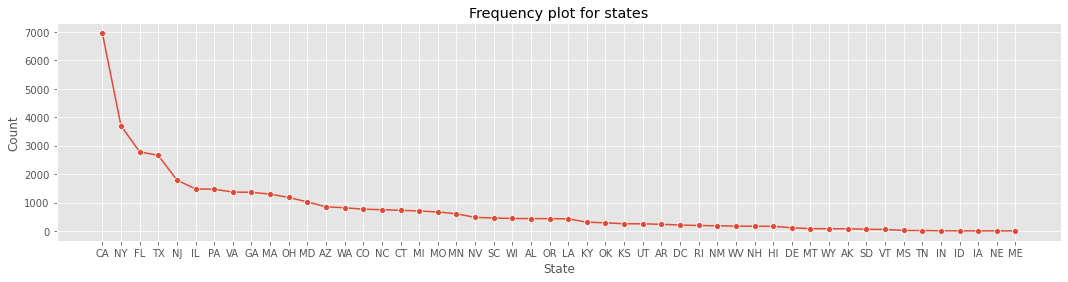

In [31]:
plt.figure(figsize=(18,4))
sns.lineplot(data=loan.addr_state.value_counts(), marker="o")
set_plot_labels("State","Count","Frequency plot for states")
plt.plot()

We can see that the california has the highest borrower followed by new york

##### Lets analyze few other variables

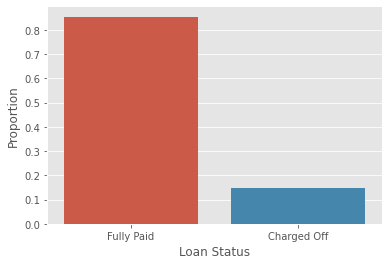

In [32]:
sns.barplot(data=loan.loan_status.value_counts(normalize=True).reset_index(), x = 'index', y='loan_status')
set_plot_labels("Loan Status", "Proportion")
plt.show()

Parameter `normalize` will return relative frequencies

This gives an idea that 15% borrower has charged off

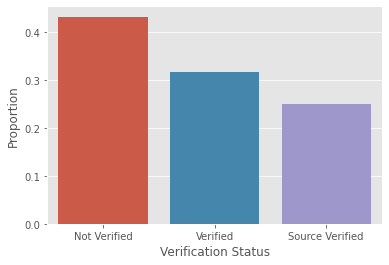

In [33]:
sns.barplot(data=loan.verification_status.value_counts(normalize=True).reset_index(), x = 'index', y='verification_status')
set_plot_labels("Verification Status", "Proportion")
plt.show()

In [34]:
loan.verification_status.value_counts(normalize=True)

Not Verified       0.432745
Verified           0.316406
Source Verified    0.250849
Name: verification_status, dtype: float64

We can see the sum of Verified and source verified is coming to 56% and not verified is coming to 45%. Which is not really matching with 15% charged off, that means the unverified borrowed are not necessarily charging off

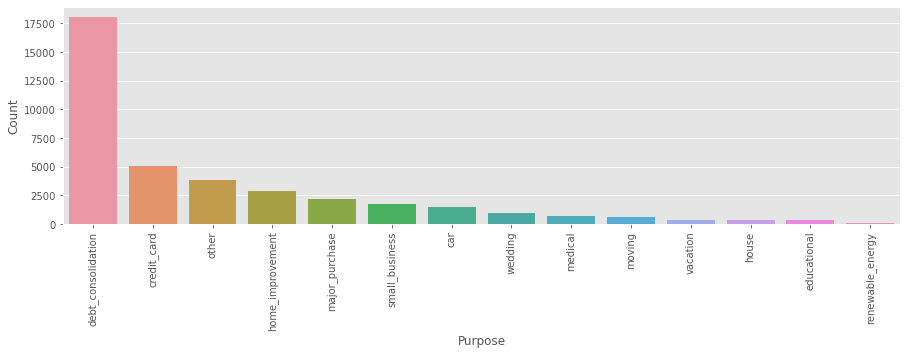

In [35]:
plt.figure(figsize=(15, 4))
sns.countplot(data=loan, x="purpose", order=loan.purpose.value_counts().index)
set_plot_labels("Purpose", "Count")
plt.xticks(rotation=90)
plt.show()

Looks like most of them are taking loan for *Debt Consolidation*

##### Lets have a look at some quantitative variables

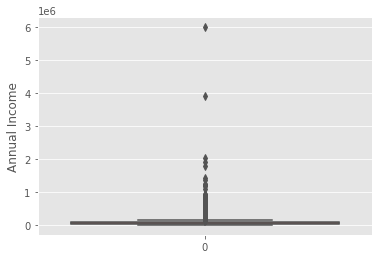

In [36]:
sns.boxplot(data=loan.annual_inc)
plt.ylabel("Annual Income")
plt.show()

There are clearly some outliers which is skewing the data, let's have look of data at different quantile

In [37]:
loan.annual_inc.quantile([0.5, 0.95, 0.97, 0.98, 0.99])

0.50     58868.0
0.95    140004.0
0.97    165000.0
0.98    187000.0
0.99    234144.0
Name: annual_inc, dtype: float64

Let remove the outliers

In [38]:
loan = loan[loan.annual_inc <= loan.annual_inc.quantile(0.98)]

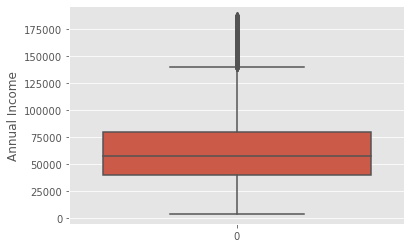

In [39]:
sns.boxplot(data=loan.annual_inc)
plt.ylabel("Annual Income")
plt.show()

In [40]:
loan.annual_inc.describe()

count     37807.000000
mean      63882.857307
std       32295.149781
min        4000.000000
25%       40000.000000
50%       57600.000000
75%       80000.000000
max      187000.000000
Name: annual_inc, dtype: float64

We can see the mean annual income for the borrower are around 60,000

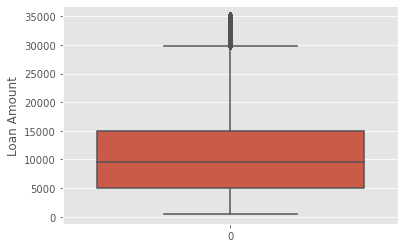

In [41]:
sns.boxplot(data=loan.loan_amnt)
plt.ylabel("Loan Amount")
plt.show()

In [42]:
loan.funded_amnt.describe()

count    37807.000000
mean     10631.478298
std       6956.351622
min        500.000000
25%       5000.000000
50%       9250.000000
75%      14750.000000
max      35000.000000
Name: funded_amnt, dtype: float64

Average amount received to borrower is around 10,000

In [43]:
loan.int_rate.describe()

count    37807.000000
mean        11.909252
std          3.681528
min          5.420000
25%          8.940000
50%         11.710000
75%         14.350000
max         24.400000
Name: int_rate, dtype: float64

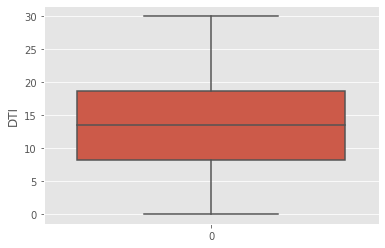

In [44]:
sns.boxplot(data=loan.dti)
plt.ylabel("DTI")
plt.show()

##### Binning annual income

In [45]:
loan["annual_inc_bin"] = pd.cut(loan.annual_inc, 20).apply(lambda x : str(round(float(x.left)/1000, 1))+"K"+ " - " + str(round(float(x.right)/1000, 1))+"K" )

#### Multivariate Analysis

Let's have a look at segmented and multivariate analysis to see a pattern

##### Lets see how term and loan amount are related

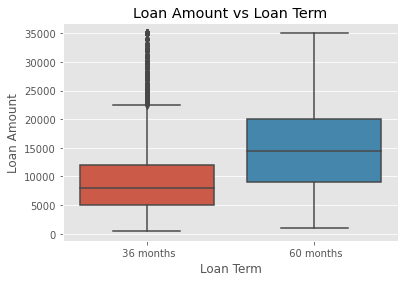

In [46]:
sns.boxplot(data=loan, x="term", y=loan.loan_amnt)
set_plot_labels("Loan Term", "Loan Amount", "Loan Amount vs Loan Term")
plt.show()

Here we can see that the Loan amount is more for higher term loan which make sense

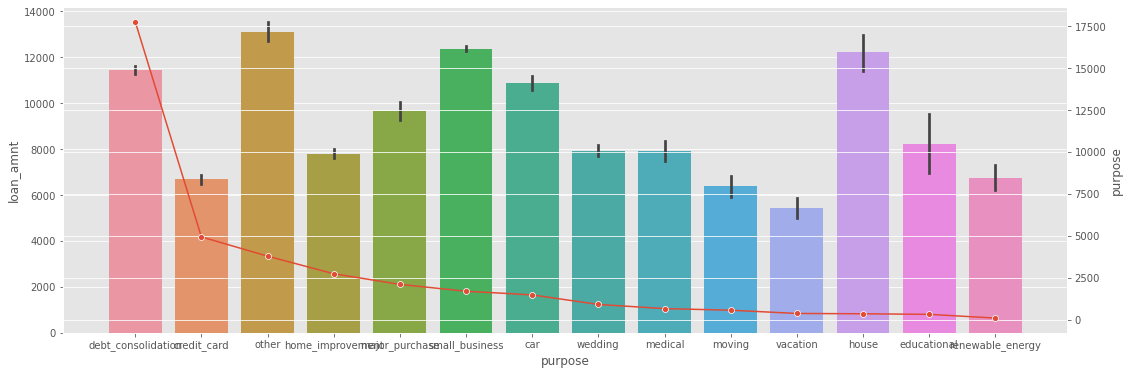

In [47]:
fig, ax1 = plt.subplots(figsize=(18,6))
sns.barplot(x="purpose", y="loan_amnt", data=loan, ax=ax1)
ax2 = ax1.twinx()
x=loan.purpose.value_counts().reset_index()
sns.lineplot(data=x, x="index", y="purpose", palette="pastel", ax=ax2, marker="o")
plt.show()

The number of loans for debt consolidation are higher plus the loan amount is also in the higher range

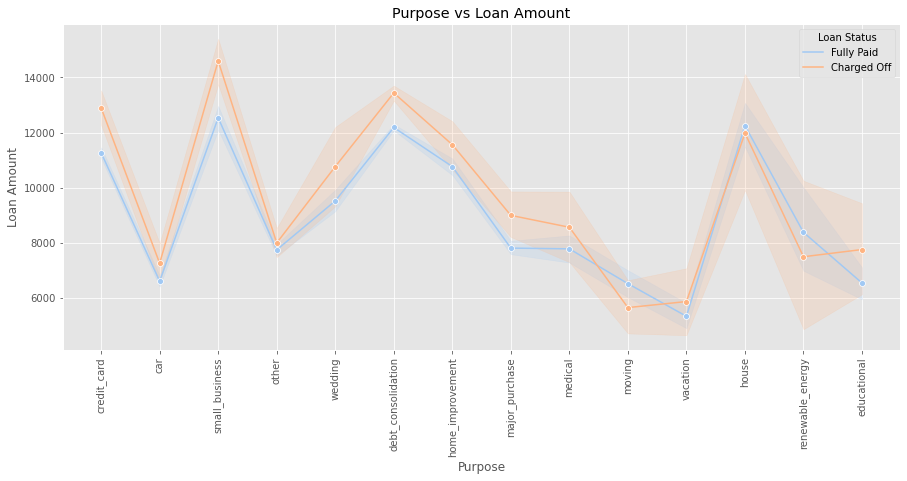

In [48]:
plt.figure(figsize=(15,6))
sns.lineplot(data =loan,y='loan_amnt', x='purpose', hue ='loan_status',palette="pastel", marker="o")
set_plot_labels("Purpose", "Loan Amount", "Purpose vs Loan Amount")
plt.xticks(rotation=90)
plt.legend(title="Loan Status")
plt.show()

**Conclusion:** Higher loan amount is likely to charge of especially in case of `small business` and `debt consolidation`.

##### Lets see how loan amount and interest rate are related

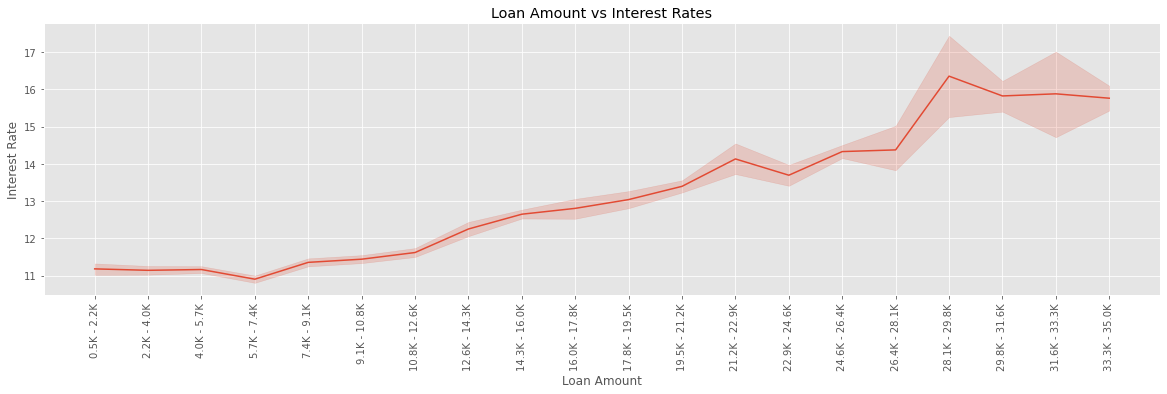

In [49]:
plt.figure(figsize=(20, 5))
sns.lineplot(y="int_rate", x="loan_amnt_bin", data=loan)
set_plot_labels("Loan Amount", "Interest Rate", "Loan Amount vs Interest Rates")
plt.xticks(rotation=90)
plt.show()

We can see increase in loan amount increase interest rate

##### Lets see how states are related to loan status

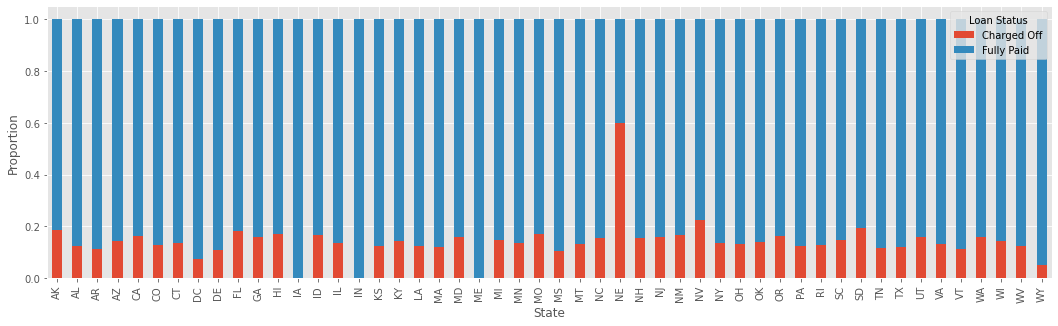

In [50]:
state_vs_status = pd.crosstab(index=loan.addr_state, columns=loan.loan_status, normalize='index')
state_vs_status.plot(kind="bar", stacked=True, figsize=(18, 5), xlabel="State", ylabel="Proportion")
plt.legend(title="Loan Status")
plt.show()

This shows that the state of `NE` is highly possible to Charge Off, lets see what is the count of this state

In [51]:
loan[loan.addr_state == "NE"].shape

(5, 22)

Althought proportion wise the state of `NE` has charged off the most, the count of the borrowers in `NE` is the least, so this value can be ignored

**Conclusion:** The state of the borrower does not influence the charge off

##### Let's see how the interest rate is related to charge-off

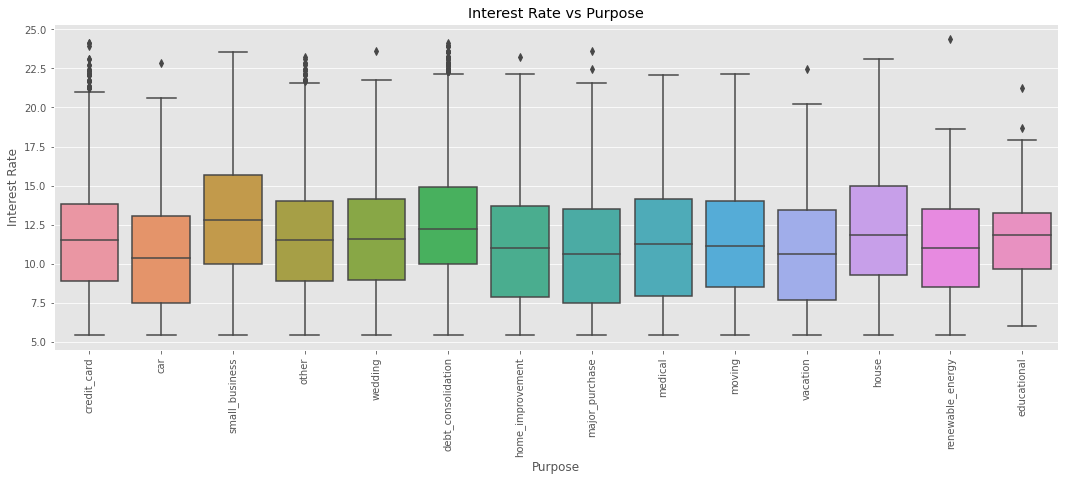

In [52]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=loan, x="purpose", y="int_rate")
set_plot_labels("Purpose", "Interest Rate", "Interest Rate vs Purpose")
plt.xticks(rotation=90)
plt.show()

Interest rate are generally higher for `small_business`

In [53]:
loan.groupby(by="loan_status").mean()["int_rate"]

loan_status
Charged Off    13.799130
Fully Paid     11.584156
Name: int_rate, dtype: float64

Lets analyze it across the purpose and see the result

In [54]:
status_interest_purpose = pd.pivot_table(data=loan, index="purpose", columns="loan_status", values="int_rate", aggfunc=np.mean)

In [55]:
status_interest_purpose

loan_status,Charged Off,Fully Paid
purpose,,
car,12.372813,10.244610
credit_card,13.409869,11.383837
debt_consolidation,14.256970,12.027673
educational,12.772407,11.430340
home_improvement,13.291224,10.951705
house,15.149474,11.527872
major_purchase,12.805890,10.531383
medical,13.322642,11.067135
moving,12.288778,11.314937


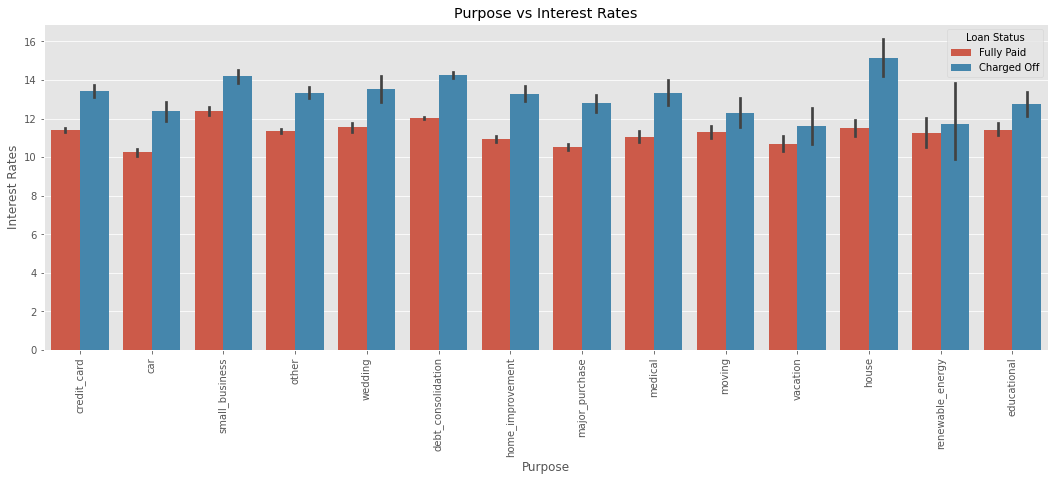

In [56]:
plt.figure(figsize=(18, 6))
sns.barplot(data=loan, x="purpose", y="int_rate", hue="loan_status")
set_plot_labels("Purpose", "Interest Rates", "Purpose vs Interest Rates")
plt.legend(title="Loan Status")
plt.xticks(rotation=90)
plt.show()

**Conclusion** Although the average rate of interest for `small_business` is higher, when we drill down we realize that the average `int_rate` are higher in `house` category for those who charged off

So if a housing category is having higher rate of interest the borrower will likely charge off

##### Lets have a look at how the verification status and loan amount is related to chargeoff

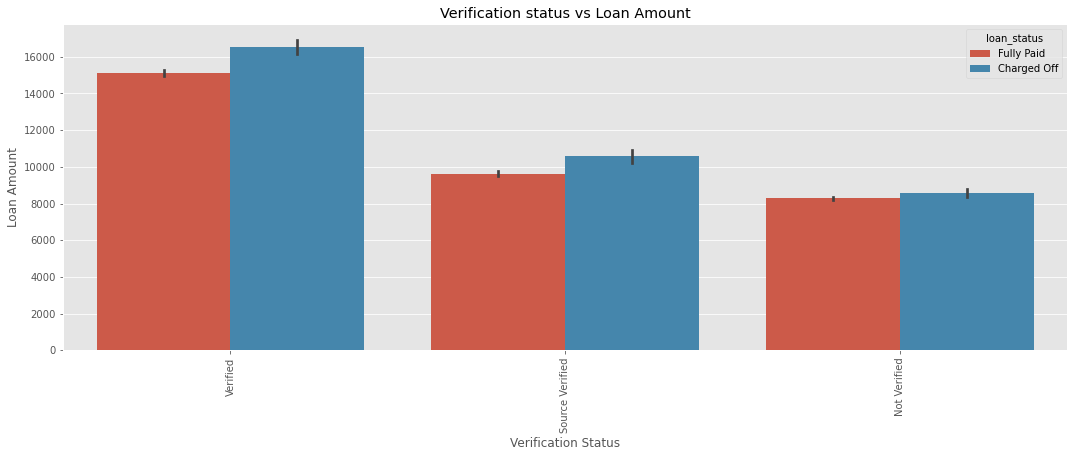

In [57]:
plt.figure(figsize=(18, 6))
sns.barplot(data=loan, x="verification_status", y="loan_amnt", hue="loan_status")
set_plot_labels("Verification Status", "Loan Amount", "Verification status vs Loan Amount")
plt.xticks(rotation=90)
plt.show()

**Conclusion** On an average if a loan amount is higher borrower is likely to charge-off, it does not depend whether borrower is verified or not

##### Lets have a look how home_ownership are dependent on loan status

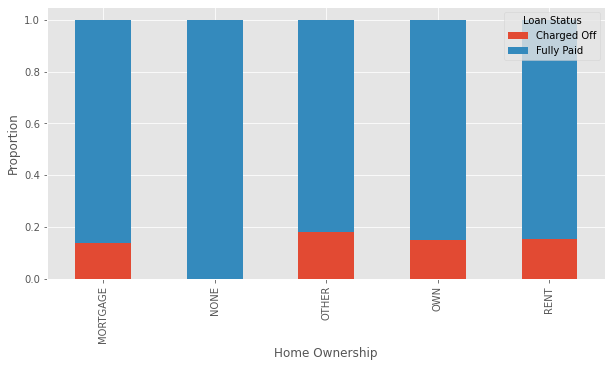

In [58]:
loan.groupby("home_ownership")["loan_status"].value_counts(normalize='index').unstack().plot(kind='bar',stacked=True, figsize=(10, 5), xlabel="Home Ownership", ylabel="Proportion")
plt.legend(title="Loan Status")
plt.show()

**Conclusion:** There seems to be no correlation between home_ownership and charge-offs

##### Lets analyze how grades influence

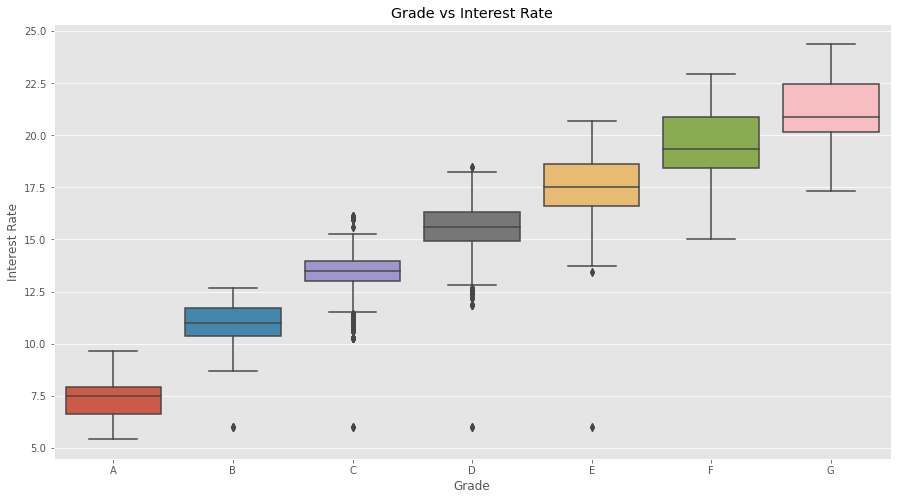

In [59]:
plt.figure(figsize=(15, 8))
order = loan.grade.unique()
order.sort()
sns.boxplot(x='grade', y="int_rate", order = order, data=loan)
set_plot_labels("Grade", "Interest Rate", "Grade vs Interest Rate")
plt.show()

We can see as the Grades decreases the rate of interest increase

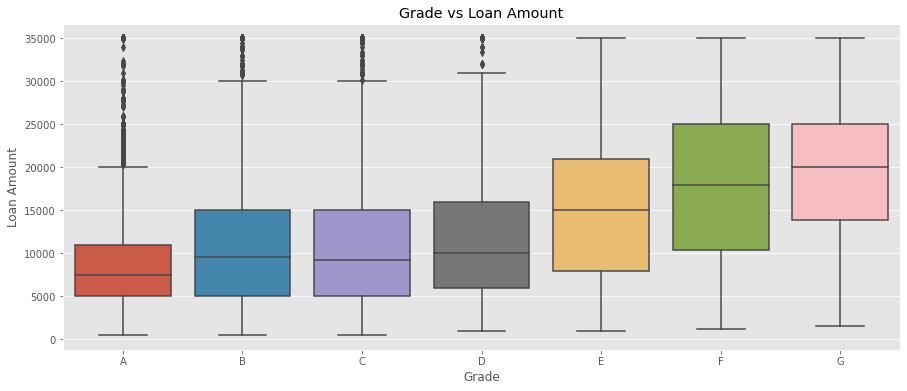

In [60]:
plt.figure(figsize=(15, 6))
order = loan.grade.unique()
order.sort()
sns.boxplot(x='grade', y="loan_amnt", order = order, data=loan)
set_plot_labels("Grade", "Loan Amount", "Grade vs Loan Amount")
plt.show()

The loan amount request for lower grades are generally higher

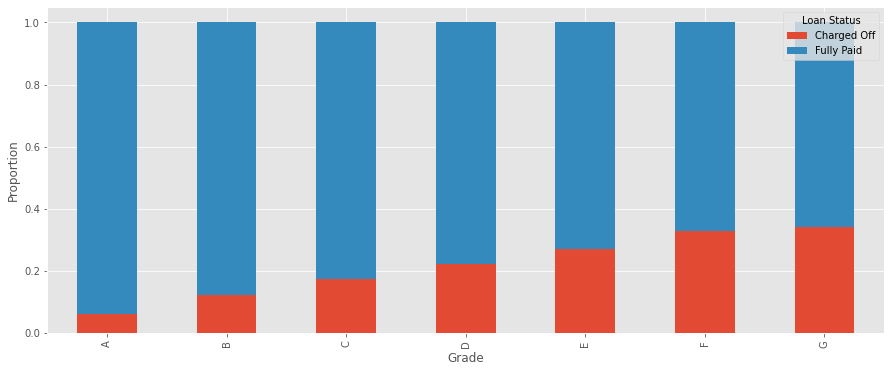

In [61]:
loan.groupby("grade")["loan_status"].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(15, 6), xlabel="Grade", ylabel="Proportion")
plt.legend(title="Loan Status")
plt.show()

**Conclusion:** Loan with Lower grades generally has higher loan amount and are more likely to charge off

##### Lets analyze influence of annual income and DTI

In [62]:
loan.groupby("loan_status")["dti"].mean()

loan_status
Charged Off    14.063037
Fully Paid     13.247590
Name: dti, dtype: float64

Borrower with higher DTI is more likely to charge off, lets look deeper by comparing it with annual income

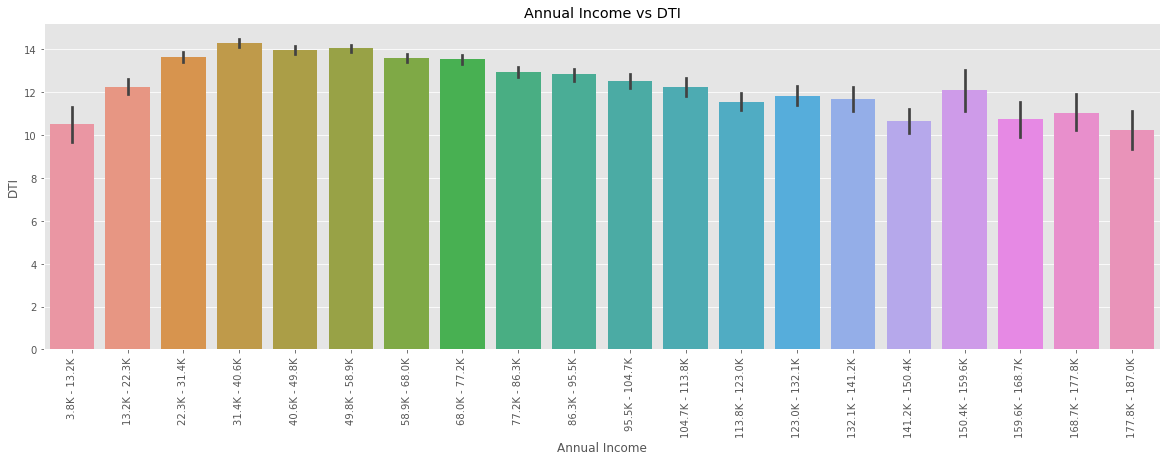

In [63]:
plt.figure(figsize=(20, 6))
sns.barplot(x="annual_inc_bin", y="dti", data=loan)
set_plot_labels("Annual Income", "DTI", "Annual Income vs DTI")
plt.xticks(rotation=90)
plt.show()

Borrower in the range of annual income 31k to 40k has higher dti

In [64]:
loan.annual_inc_bin.value_counts().sort_values(ascending=False).head()

49.8K - 58.9K    4974
31.4K - 40.6K    4890
58.9K - 68.0K    4694
40.6K - 49.8K    4539
68.0K - 77.2K    3443
Name: annual_inc_bin, dtype: int64

Borrowers in the range 31k to 40k are among the highest

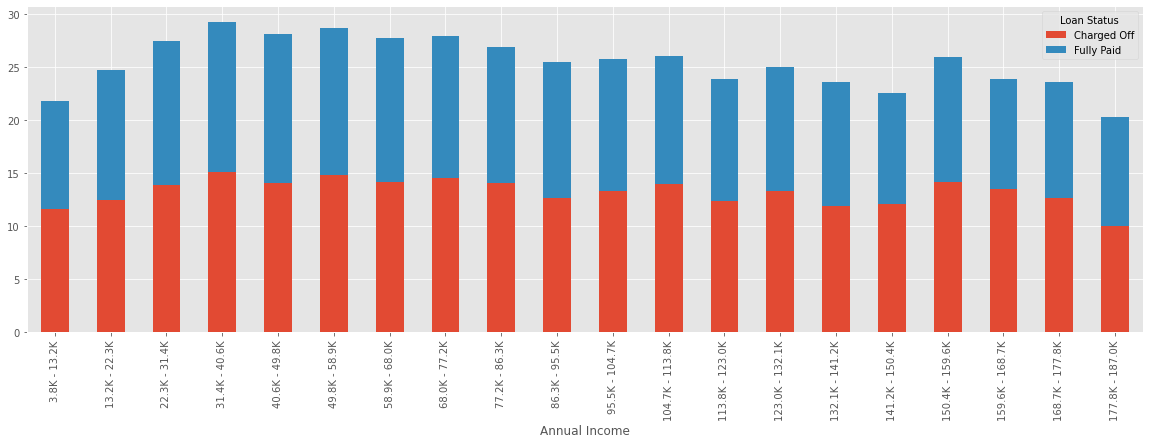

In [65]:
loan.pivot_table(index="annual_inc_bin", columns="loan_status", values="dti", aggfunc='mean').plot(kind="bar", stacked=True, figsize=(20, 6), xlabel="Annual Income")
plt.legend(title="Loan Status")
plt.show()

**Conclusion:** Borrowers with the annual income ranges from 31k to 40k have higher DTI rates and are like to charge off more

##### Lets have a look at annual income and loan amount

We have seen borrowers in the annual income range 31k-40k and 50k-59k are the highest. Lets look at the loan amount they request

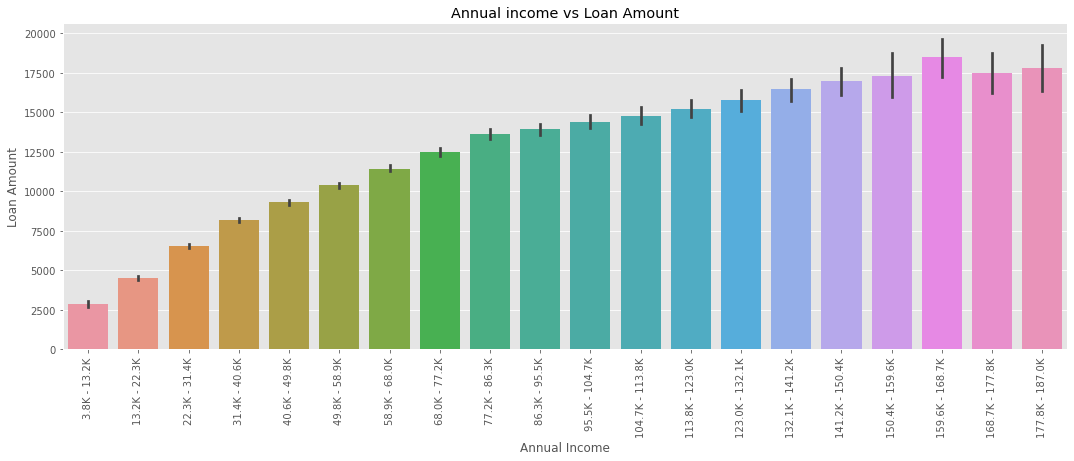

In [66]:
plt.figure(figsize=(18,6))
sns.barplot(data=loan, x="annual_inc_bin", y="loan_amnt")
set_plot_labels("Annual Income", "Loan Amount", "Annual income vs Loan Amount")
plt.xticks(rotation=90)
plt.show()

We can see the loan amount are based on income which make sense

##### Let's analyze how the time of the year influences

In [67]:
loan['issue_month']=loan['issue_d'].str.partition("-", True)[0]  

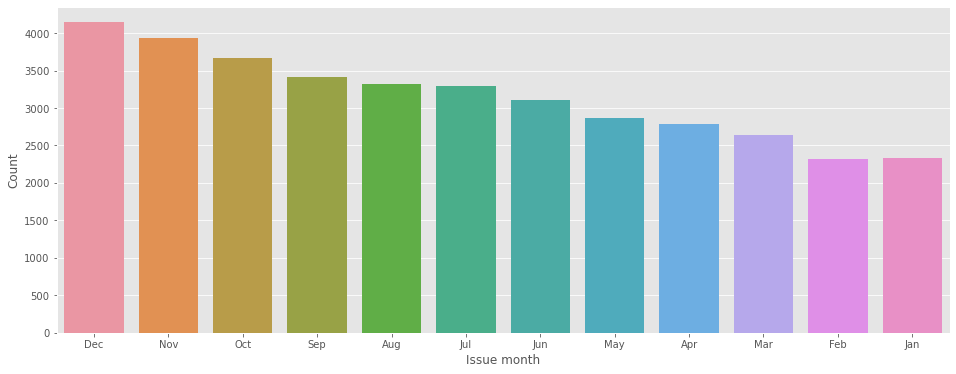

In [68]:
plt.figure(figsize=(16,6))
sns.countplot(data=loan, x="issue_month")
set_plot_labels("Issue month", "Count")
plt.show()

We can see in the month of Dec more loan is being taken, lets for what purpose this loan was taken for

In [69]:
month_purpose = loan.groupby("issue_month")["purpose"].value_counts().unstack()

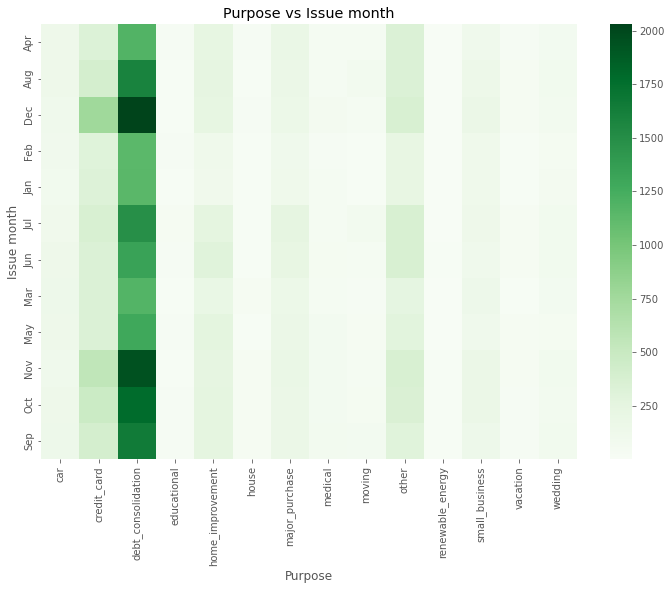

In [70]:
plt.figure(figsize=(12,8))
sns.heatmap(data=month_purpose, cmap = "Greens")
set_plot_labels("Purpose", "Issue month", "Purpose vs Issue month")
plt.show()

**Conclusion:** Here we can see that in month of Aug, Sept, Oct Nov, Dec borrowers are taking loan for debt_consolidation

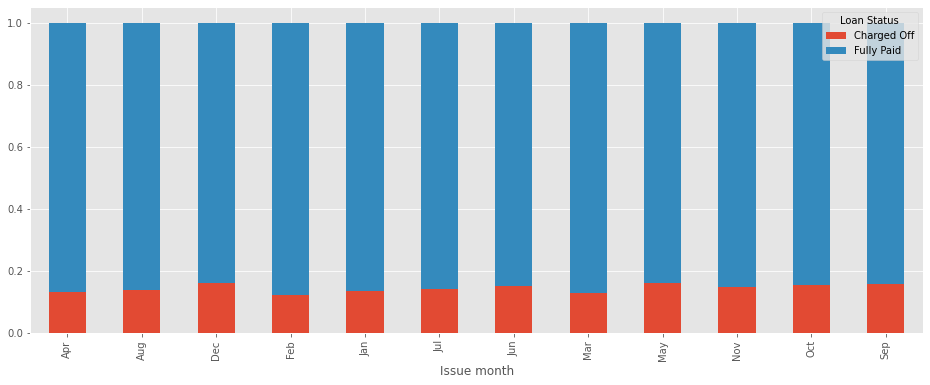

In [71]:
loan.groupby("issue_month")["loan_status"].value_counts(normalize=True).unstack().plot(kind="bar", stacked=True, figsize=(16, 6), xlabel="Issue month")
plt.legend(title="Loan Status")
plt.show()

In month of Dec overall charge off is not significant, lets drilldown for `debt-consolidation` category and see

Fully Paid     15036
Charged Off     2743
Name: loan_status, dtype: int64

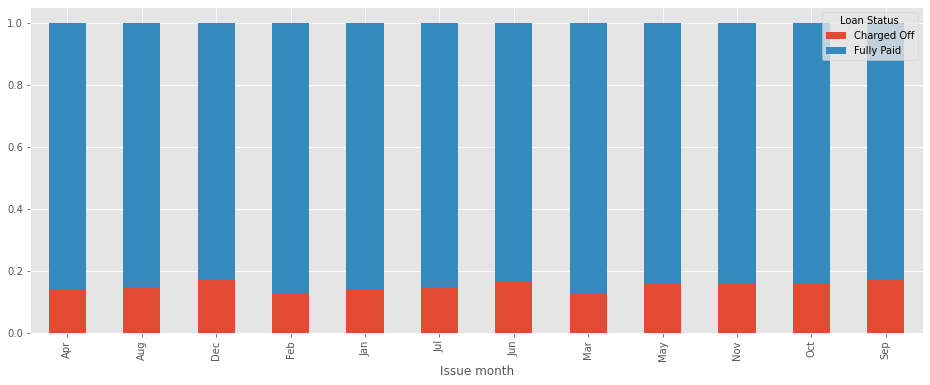

In [72]:
debt_consol = loan[loan.purpose == "debt_consolidation"]
debt_consol.groupby("issue_month")["loan_status"].value_counts(normalize=True).unstack().plot(kind="bar", stacked=True, figsize=(16, 6), xlabel="Issue month")
plt.legend(title="Loan Status")
debt_consol.loan_status.value_counts()

There's no significant increase in charge off to `debt_consolidation` in the last quarter

##### Let's see how emp_length influences

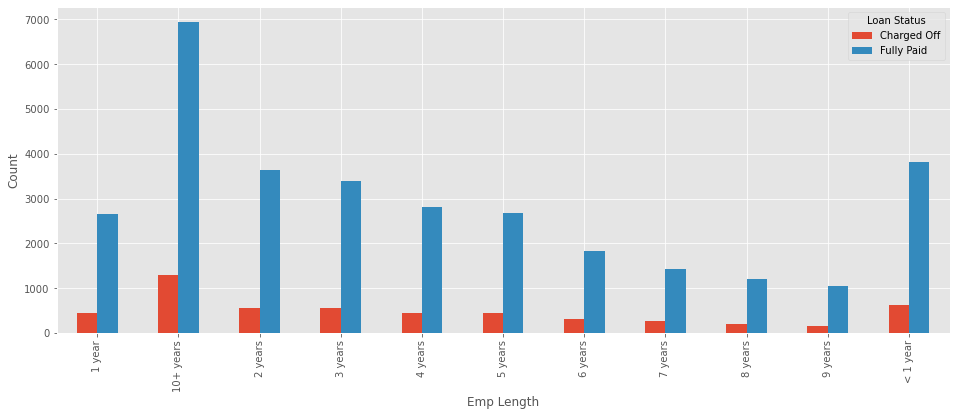

In [73]:
loan.groupby("emp_length")["loan_status"].value_counts().unstack().plot(kind="bar", figsize=(16, 6), xlabel="Emp Length", ylabel="Count")
plt.legend(title="Loan Status")
plt.show()

In [74]:
emp_length_purpose = loan.groupby("emp_length")["purpose"].value_counts().unstack()

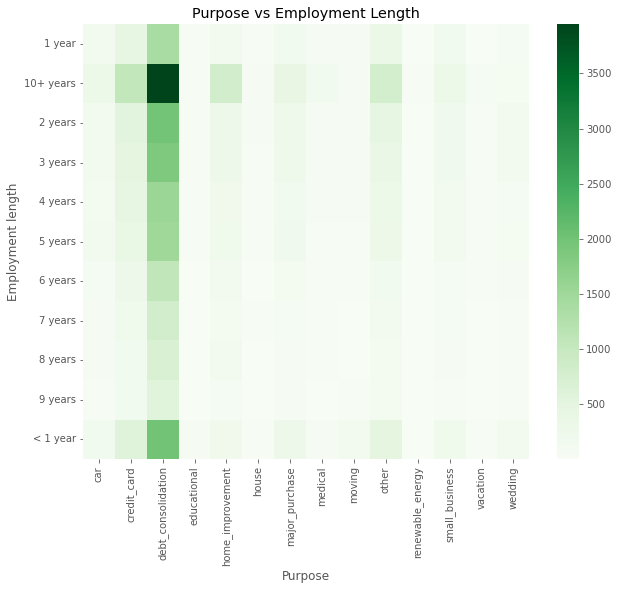

In [75]:
plt.figure(figsize=(10, 8))
sns.heatmap(data=emp_length_purpose, cmap="Greens")
set_plot_labels("Purpose", "Employment length", "Purpose vs Employment Length")
plt.show()

**Conclusion:** Employees having exp greater than 10 year is borrowing the most and mainly for debt_consolidation

### Observation and recommendation

- Overall 15% of the borrower charges-off
- State of california has the highest borrower number. But overall charge-offs are independent of the state of the borrower. Although the state of Nebraska has higher percent of charge-off the number of borrowers are also very less, so it can be consider as coincedential
- Whether the source is verified or not it does not really impact the charge-offs
- Most of the loans are taken for Debt Consolidation. Loan taken for debt consolidation and small businesses with higher loan amount are likely to charge off
- Most of the loans are taken in the month of Oct, Nov and Dec again mainly for Debt Consolidation, but there is no unusal increase in charge during this period for Debt Consolidation purpose
- Average annual income of the borrowers are around 60k. Borrower with annual income ranges from 30k to 40k have higher DTI and are more likely to charge-off
- If a loan amount is higher the term is also more and there is a likely of charge-off
- Verification status of the borrower does not guarantee that there will be no charge-offs
- The rate of interest increases with the loan amount
- Interest rates are higher for small business.
- If a borrower is taking a loan for housing and rate of interest is higher then the borrower is likely to charge-off
- Loan with Lower grades generally has higher loan amount and are more likely to charge off
- Employees having exp greater than 10 year is borrowing the most and mainly for debt_consolidation
- Loan amount requested are based on annual income which make sense